# Tutorial for fitting Pr2Sn2O7 neutron scattering data to a CEF model

data taken from Princep et al, PRB (2013) http://dx.doi.org/10.1103/PhysRevB.88.104421

In [1]:
## Import libraries

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import PyCrystalField as cef
from scipy.optimize import curve_fit

 *******************************************************
 *                PyCrystalField 2.3.5                 *
 *  Please cite  J. Appl. Cryst. (2021). 54, 356-362   * 
 *    <https://doi.org/10.1107/S160057672001554X>      *
 *******************************************************



# A) Import data

Instructions: run the cell below.

<IPython.core.display.Javascript object>


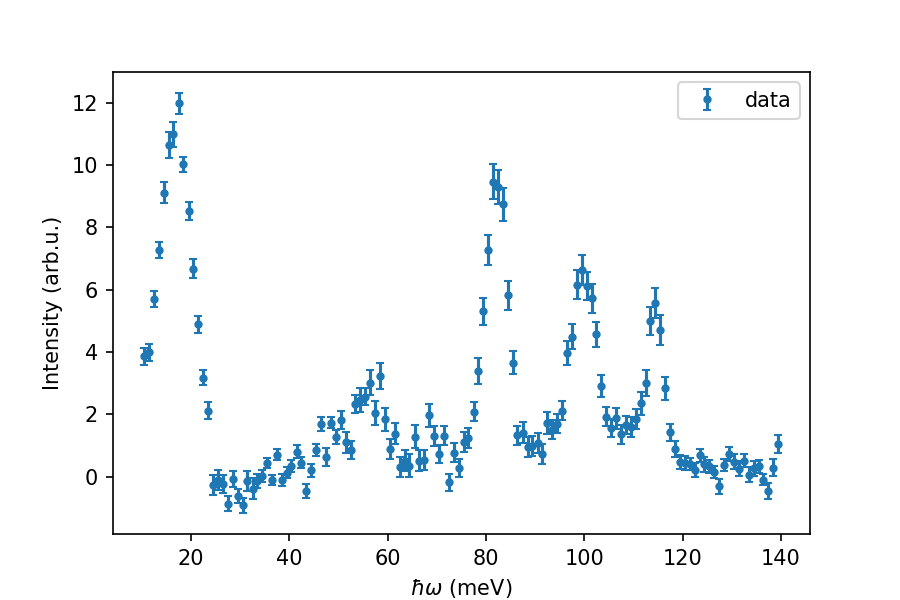

Text(0, 0.5, 'Intensity (arb.u.)')

In [2]:
## Import the data
data = np.genfromtxt('Princep_Fig2.txt', unpack=True)


###### Plot result
plt.figure(figsize=(6,4))
plt.errorbar(data[0], data[1], data[2], 
             marker='.', ls='none', capsize=2, label='data')
# plot labels
plt.legend()
plt.xlabel('$\\hbar \\omega$ (meV)')
plt.ylabel('Intensity (arb.u.)')

# B) Fit the eigenvalues

Instructions:
fill in the mode energies in the p0 function below

<IPython.core.display.Javascript object>


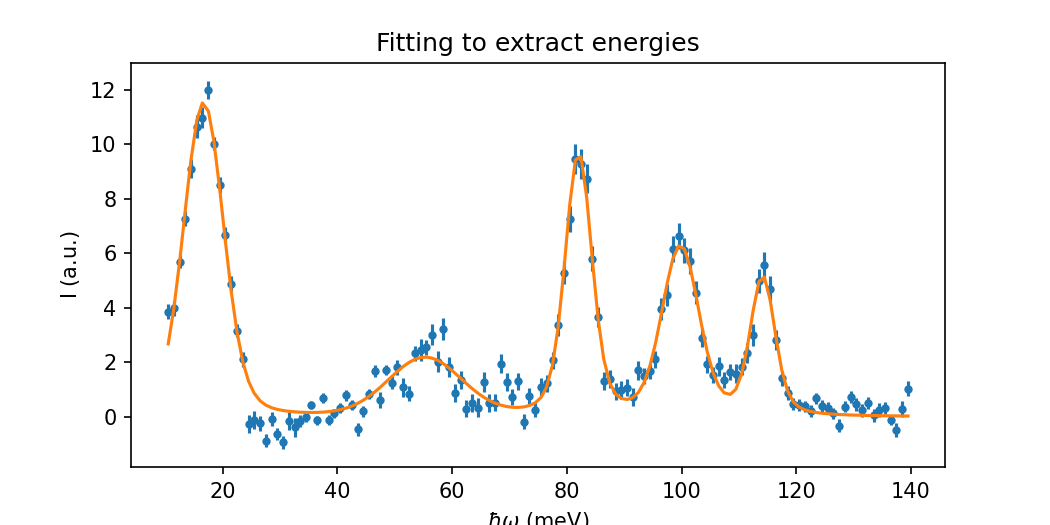

In [3]:
############### Functions used to fit the Eigenvalues

from scipy.special import wofz

def voigt(x, a, x0, alpha, gamma):
    """ Return the Voigt line shape at x with Lorentzian component FWHM gamma
    and Gaussian component FWHM alpha."""
    sigma = (0.5*alpha) / np.sqrt(2 * np.log(2))
    return a*np.real(wofz(((x-x0) + 1j*(0.5*gamma))/sigma/np.sqrt(2))) / sigma\
                                                        /np.sqrt(2*np.pi)


def peakfitfun(x, a0,x0,w0, a1,x1,w1, a2,x2,w2, a3,x3,w3, a4,x4,w4, lw):
    '''five Voigt functions for the five peaks. Each has its own Gaussian width,
    but all have the same Lorentzian width "lw".'''
    return voigt(x, a0,x0,w0, lw) +\
           voigt(x, a1,x1,w1, lw) +\
           voigt(x, a2,x2,w2, lw) +\
           voigt(x, a3,x3,w3, lw) +\
           voigt(x, a4,x4,w4, lw)  


###############

# Make a guess at the starting parameters:
p0 = [96,16,3,  35,55,4,  56,83,2,  29,99,2,  25,114,2,  1]


## Fit the gausfitfunction to the experimental data
poptinitial, pcovinitial = curve_fit(peakfitfun, data[0], data[1], sigma=data[2], p0=p0)
#uncertainty is square root of covariance matrix diagonal
uncinitial = np.sqrt(np.diag(pcovinitial))
LorWidthInitial = poptinitial[-1]  # initial fitted Lorentzian width


############ Plot results
f, ax = plt.subplots(figsize=(7,3.5))

ax.errorbar(data[0], data[1], data[2], marker='.', ls='none')
ax.plot(data[0], peakfitfun(data[0], *poptinitial), zorder=10)
ax.set_xlabel('$\\hbar \\omega$ (meV)')
ax.set_ylabel('$\\rm I$ (a.u.)')
ax.set_title('Fitting to extract energies')

ObservedEnergies = [poptinitial[3*i+1] for i in range(0,5)]
ObservedEnergiesUnc = [uncinitial[3*i+1] for i in range(0,5)], 
ObservedWidths =  [poptinitial[3*i+2] for i in range(0,5)]
ObservedWidthsUnc = [uncinitial[3*i+2] for i in range(0,5)]


## Define resolution function from the fitted mode widths, linearly interpolating between them.
def resfunc(hw):
    return np.interp(hw, ObservedEnergies, ObservedWidths)

# C) Generate point charge model

Instructions: fill in the importCIF function with the .cif file and the ion 

In [5]:
PSOLig, Pr = cef.importCIF('Pr2Sn2O7.cif', 'Pr1')
Pr.printEigenvectors()

Importing atoms
   88 atoms added
.cif import complete.
Central ion: Pr3+ at [0.5, 0.5, 0.5]
    AAAH! There is a super-close atom. Removing it...
 Nearest ligand: O2-
   Identified 8 O2- ligands.
   Found 3 fold axis about [1. 1. 1.]
   Found mirror plane: [-0.70710678  0.          0.70710678]

  Axes for point charge model (in ABC space):
        X axis = [-0.5  1.  -0.5] 
        Y axis = [-1.  0.  1.] 
        Z axis = [1. 1. 1.] 

   Creating a point charge model...
B_2 0  =  -0.643611
B_2 1  =  -0.0
B_2 2  =  0.0
B_4 0  =  -0.04072296
B_4 1  =  0.0
B_4 2  =  -0.0
B_4 3  =  0.30489587
B_4 4  =  0.0
B_6 0  =  0.00042397
B_6 1  =  -0.0
B_6 2  =  -0.0
B_6 3  =  0.00386348
B_6 4  =  0.0
B_6 5  =  -0.0
B_6 6  =  0.00402167

 Eigenvalues 	 Eigenvectors
		----------------------------------------------------------------------
0.00000 	|  [ 0.909  0.     0.     0.408  0.     0.    -0.078  0.     0.   ]  |
0.00000 	|  [ 0.     0.    -0.078  0.     0.    -0.408  0.     0.     0.909]  |
14.98

# D) Fit point charge model to data

As a first pass, we will fit the effective charges of the model to the data.

#### Instructions:
set the fitargs to be 'LigandCharge' and 'prefactor'

In [6]:
# Step one is figuring out which ions are symmetry equivalent. For this ion, it's easy.
print(PSOLig.bonds)
symequiv = [0,0,1,1,1,1,1,1]

[[ 0.          0.          2.29505392]
 [ 0.          0.         -2.29505392]
 [-1.27023574 -2.20011283 -0.49866932]
 [ 2.54047147  0.         -0.49866932]
 [-2.54047147  0.          0.49866932]
 [ 1.27023574  2.20011283  0.49866932]
 [ 1.27023574 -2.20011283  0.49866932]
 [-1.27023574  2.20011283 -0.49866932]]


In [7]:
def GlobalError(LigandsObject, LigandCharge, symequiv):

    # Build Hamiltonian
    newH = LigandsObject.PointChargeModel(symequiv, LigandCharge=LigandCharge, printB=False)
    newH.diagonalize()

    # Compute error in eigenvalues
    CalculatedEnergies = np.unique(np.around(newH.eigenvalues.real,6))[1:]
    erro=np.nansum((CalculatedEnergies - ObservedEnergies)**2)
    
    # # Compute error in eigenvalues with determinant method (if all are not known)
    # ## Thanks to Guannan Zhang
    # erro = np.sum([np.real(np.linalg.det(newH.H - ev*np.identity(len(newH.H))))**2 
    #               for ev in ObservedEnergies])

    print(erro, end='\r')
    return erro 


#************************************************************
# Fit point charges to neutron data

fitargs = ['LigandCharge']

Pr3fit, FitVals = PSOLig.FitChargesNeutrons(chisqfunc = GlobalError,  fitargs = fitargs,
                         LigandCharge = [-2.0,-2.0], symequiv=symequiv)

	Fitting...
152.24232363927268
#*********************************
# Final Stevens Operator Values
B_2 0  =  -0.60125203
B_2 1  =  -0.0
B_2 2  =  0.0
B_4 0  =  -0.03959205
B_4 1  =  0.0
B_4 2  =  -0.0
B_4 3  =  0.29705281
B_4 4  =  0.0
B_6 0  =  0.00041169
B_6 1  =  -0.0
B_6 2  =  -0.0
B_6 3  =  0.0037641
B_6 4  =  0.0
B_6 5  =  -0.0
B_6 6  =  0.00391822

Final Charges:  [-1.94283179 -1.94855255]
Final EigenValues:  [  0.      0.     13.651  57.973  57.973  89.495 101.628 101.628 105.368]


# E) Fit CEF operators directly to data

Instructions: define 'fitargs' to be 'coeff' and 'prefactor' in the cell below.

In [8]:
def err_global(CFLevelsObject, coeff, gamma, prefactor):
    """Global error function used for fitting"""
    
    # define new Hamiltonian
    CFLevelsObject.newCoeff(coeff)

    # Compute error in eigenvalue
    CalculatedEnergies = np.unique(np.around(CFLevelsObject.eigenvalues.real,4))[1:]
    erro=np.nansum((CalculatedEnergies - ObservedEnergies)**2)*10
    
    # Compute error in neutron spectrum
    calculatedNeutronSpectrum = prefactor*CFLevelsObject.normalizedNeutronSpectrum(Earray=data[0], Temp = 5, 
                                                                           ResFunc= resfunc, gamma=gamma )
    erro += np.sum(( (calculatedNeutronSpectrum - data[1])/data[2])**2)
    
    print(erro, end='\r')
    return erro


#************************************************************
# Fit to neutron data

gammaguess = LorWidthInitial

FitCoefRes1 = Pr.fitdata(chisqfunc = err_global,  fitargs = ['coeff','prefactor'], 
            coeff = Pr3fit.B,  gamma=gammaguess, prefactor=20, method='Powell') # fit from fitted PC

Initial err = 8386.907276988111 	Final err = 735.3087041830653


In [9]:
FitCoefRes1

{'coeff': array([-7.95310052e-01, -3.61952789e-02,  2.87511029e-01,  2.75179816e-04,
        -1.96985410e-03,  8.59019331e-03]),
 'prefactor': array([41.72344539]),
 'Chisq': 735.3087041830653}

<IPython.core.display.Javascript object>


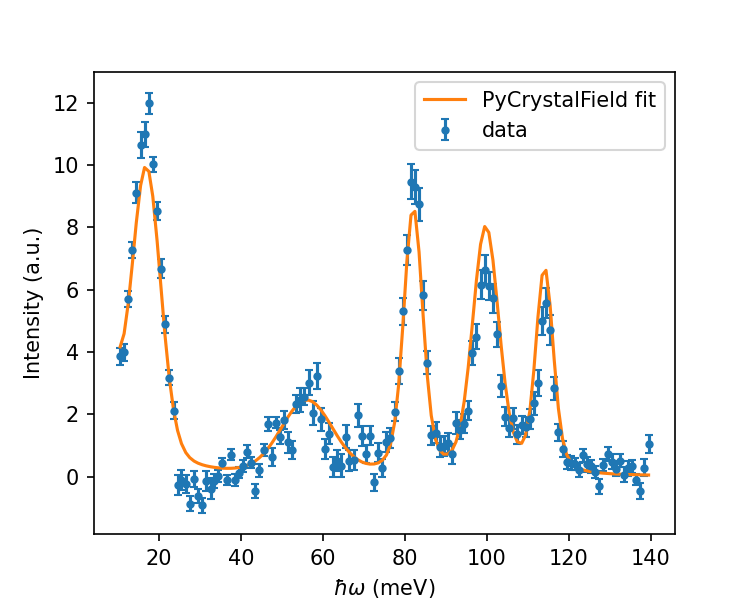

Text(0, 0.5, 'Intensity (a.u.)')

In [10]:
############# Plot results to see how good the fit is

### Build new crystal field model from the fitted result

Pr.newCoeff(FitCoefRes1['coeff'])
FittedSpectrum = Pr.normalizedNeutronSpectrum(data[0], Temp=5, ResFunc = resfunc,
                                   gamma=gammaguess)*FitCoefRes1['prefactor']

###### Plot result
plt.figure(figsize=(5,4))
plt.errorbar(data[0], data[1], data[2], marker='.', ls='none', capsize=2, label='data')
plt.plot(data[0], FittedSpectrum, label='PyCrystalField fit')
# plot labels
plt.legend()
plt.xlabel('$\\hbar \\omega$ (meV)')
plt.ylabel('Intensity (a.u.)')

#### Instructions: 
- Copy the err_global function from above, and remove the lines where we fit to the fitted eigenvalue.
- define 'fitargs' to be 'coeff', 'prefactor', and 'gamma' in cell below

In [12]:
#************************************************************
# Fit again, this time only fitting to the neutron data

def err_global(CFLevelsObject, coeff, gamma, prefactor):
    """Global error function used for fitting"""
    
    # define new Hamiltonian
    CFLevelsObject.newCoeff(coeff)

    # Compute error in neutron spectrum
    calculatedNeutronSpectrum = prefactor*CFLevelsObject.normalizedNeutronSpectrum(Earray=data[0], Temp = 5, 
                                                                           ResFunc= resfunc, gamma=gamma )
    erro = np.sum(( (calculatedNeutronSpectrum - data[1])/data[2])**2)
    
    print(erro, end='\r')
    return erro


#********************
# Fit 

FitCoefRes2 = Pr.fitdata(chisqfunc = err_global,  fitargs = ['prefactor','coeff','gamma'], 
            coeff = FitCoefRes1['coeff'],  gamma=LorWidthInitial,
                         prefactor=FitCoefRes1['prefactor'], method='Powell')


Initial err = 728.0639436576175 	Final err = 711.7448146573931


<IPython.core.display.Javascript object>


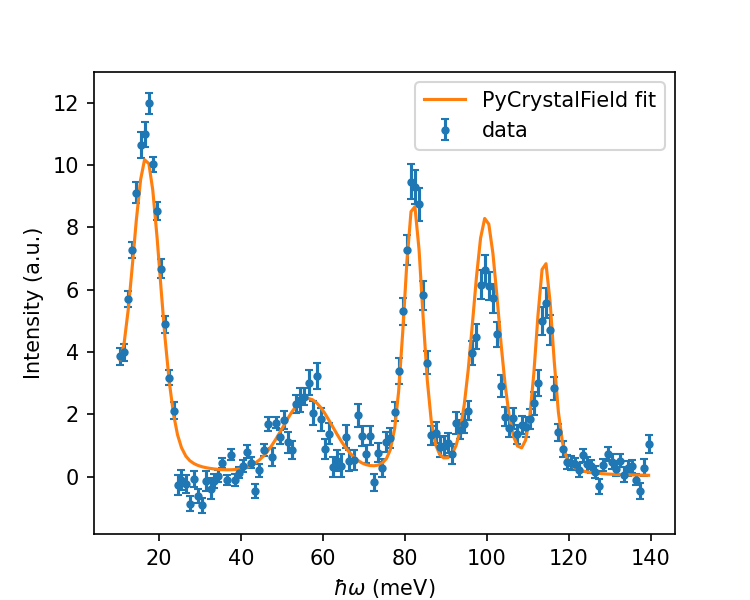

Text(0, 0.5, 'Intensity (a.u.)')

In [13]:
############# Plot results to see how good the fit is

### Build new crystal field model from the fitted result

Pr.newCoeff(FitCoefRes2['coeff'])
FittedSpectrum = Pr.normalizedNeutronSpectrum(data[0], Temp=5, ResFunc = resfunc,
                                   gamma=FitCoefRes2['gamma'])*FitCoefRes2['prefactor']

###### Plot result
plt.figure(figsize=(5,4))
plt.errorbar(data[0], data[1], data[2], marker='.', ls='none', capsize=2, label='data')
plt.plot(data[0], FittedSpectrum, label='PyCrystalField fit')
# plot labels
plt.legend()
plt.xlabel('$\\hbar \\omega$ (meV)')
plt.ylabel('Intensity (a.u.)')

# Final step: print output

In [14]:
###### Print result in LaTex tables

print('Eigenstates of PyCrystalField fit:\n')
Pr.printLaTexEigenvectors()

Eigenstates of PyCrystalField fit:

\begin{table*}
\caption{Eigenvectors and Eigenvalues...}
\begin{ruledtabular}
\begin{tabular}{c|ccccccccc}
E (meV) &$|-4\rangle$ & $|-3\rangle$ & $|-2\rangle$ & $|-1\rangle$ & $|0\rangle$ & $|1\rangle$ & $|2\rangle$ & $|3\rangle$ & $|4\rangle$ \tabularnewline
 \hline 
0.000 & -0.9441 & 0.0 & 0.0 & -0.2742 & 0.0 & 0.0 & 0.1831 & 0.0 & 0.0 \tabularnewline
0.000 & 0.0 & 0.0 & 0.1831 & 0.0 & 0.0 & 0.2742 & 0.0 & 0.0 & -0.9441 \tabularnewline
16.915 & 0.0 & 0.2948 & 0.0 & 0.0 & 0.9089 & 0.0 & 0.0 & -0.2948 & 0.0 \tabularnewline
56.316 & -0.2904 & 0.0 & 0.0 & 0.9545 & 0.0 & 0.0 & -0.068 & 0.0 & 0.0 \tabularnewline
56.316 & 0.0 & 0.0 & 0.068 & 0.0 & 0.0 & 0.9545 & 0.0 & 0.0 & 0.2904 \tabularnewline
82.062 & 0.0 & -0.6427 & 0.0 & 0.0 & 0.417 & 0.0 & 0.0 & 0.6427 & 0.0 \tabularnewline
99.752 & 0.0 & 0.0 & 0.9807 & 0.0 & 0.0 & -0.1174 & 0.0 & 0.0 & 0.1561 \tabularnewline
99.752 & 0.1561 & 0.0 & 0.0 & 0.1174 & 0.0 & 0.0 & 0.9807 & 0.0 & 0.0 \tabularnewline
114.